In [1]:
import sys
sys.path.append('../../train/')
sys.path.append('../../analyse/')

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

from util import array2mat, mat2array
from analyse_util import figure_size, set_plt, set_Border

/home/liminghong/miniconda3/envs/see/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)

preds = np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy', allow_pickle=True)
preds_old = np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_old/evaluate.npy', allow_pickle=True)

In [3]:
def _corr(_array1, _array2):
    _array1, _array2 = array2mat(_array1).copy(), array2mat(_array2).copy()
    _array1[_array1<0] = 0
    _array1 = _array1 * 10
    _array1 = np.around(_array1)

    np.fill_diagonal(_array1, np.diag(_array1)/_array1.shape[0])
    np.fill_diagonal(_array2, np.diag(_array2)/_array2.shape[0])

    _array1, _array2 = mat2array(_array1), mat2array(_array2)

    dot_product = _array1.dot(_array2.T)
    norms = np.linalg.norm(_array1) * np.linalg.norm(_array2)
    similarity = dot_product / norms
    return similarity

def get_df(preds):
    data = pd.DataFrame()
    for i in range(len(eval_set)):
        if eval_set[i]['cell_type'] == 'Endo':
            continue
        _similarity = _corr(preds[i]['predict'], preds[i]['target'])
        _data = pd.DataFrame({'similarity': [_similarity], 'cell_type': [eval_set[i]['cell_type']]})
        data = pd.concat([data, _data], axis=0, ignore_index=True)
#         data.append(_data, ignore_index=True)
    return data

preds_info, preds_old_info = get_df(preds), get_df(preds_old)
preds_info['loss'] = 'Control'
preds_old_info['loss'] = 'MSE'
data = pd.concat([preds_info, preds_old_info], axis=0, ignore_index=True)
data

,similarity,cell_type,loss
0,0.865549,ODC,Control
1,0.647887,OPC,Control
2,0.996748,OPC,Control
3,0.373363,ODC,Control
4,0.701641,ODC,Control
...,...,...,...
681,0.547105,Astro,MSE
682,0.852827,ODC,MSE
683,0.498058,Astro,MSE
684,0.926502,ODC,MSE


ODC_Control vs. ODC_MSE: Wilcoxon test (paired samples), P_val:1.999e-01 Stat=1.188e+04
Astro_Control vs. Astro_MSE: Wilcoxon test (paired samples), P_val:5.567e-02 Stat=9.730e+02
OPC_Control vs. OPC_MSE: Wilcoxon test (paired samples), P_val:1.356e-02 Stat=2.280e+02


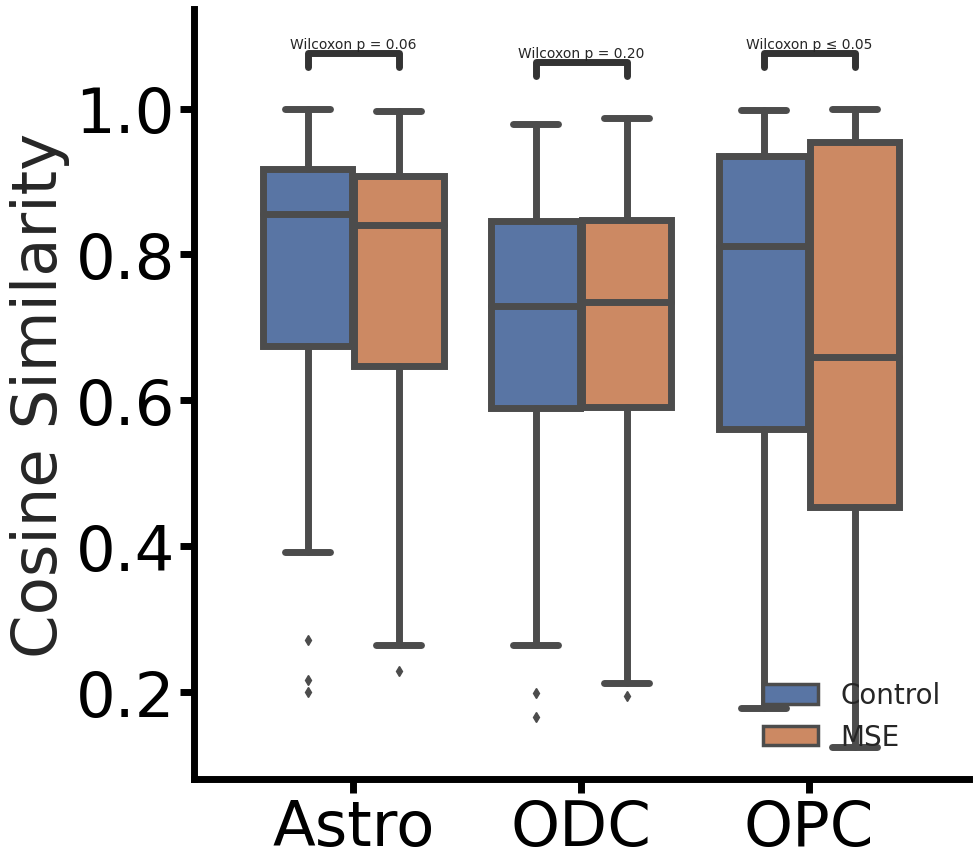

In [4]:
set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax = sns.boxplot(x='cell_type', y='similarity', data=data, hue='loss',
                 order=['Astro', 'ODC', 'OPC'], linewidth=figure_size['very_small'])

annotator = Annotator(
    ax,
    (
        [("Astro", "Control"), ("Astro", "MSE")],
        [("ODC", "Control"), ("ODC", "MSE")],
        [("OPC", "Control"), ("OPC", "MSE")],
    ),
    data=data, x='cell_type', y='similarity', hue='loss',
    order=['Astro', 'ODC', 'OPC']
)
annotator.configure(
    test='Wilcoxon', text_format='simple',
    line_width=figure_size['very_small'], fontsize=figure_size['small']
)

annotator.apply_and_annotate()

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.legend(
    frameon=False, markerscale=2, borderpad=1, borderaxespad=0, fontsize=figure_size['middle'], loc='lower right')
plt.grid(False)

plt.xlabel("")
plt.ylabel("Cosine Similarity", fontsize=figure_size['ultra'])

plt.savefig('/lmh_data/work/SEE/analyse/figure_file/consine_similarity.pdf', format='pdf', bbox_inches='tight')
plt.show()